### Import Libraries

In [13]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

import string 
import tensorflow as tf
tf.random.set_seed(2)

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
import tensorflow.keras.utils as ku



In [8]:
article_df = pd.read_csv('Data/medium_data/medium_data.csv')

### Data Preparation

In [16]:
print("Before :")
article_df['title'][0]

Before :


'A Beginner’s Guide to Word Embedding with Gensim Word2Vec Model'

In [10]:
# remove unwanted characters
article_df['title'] = article_df['title'].apply(lambda x: x.replace(u'\xa0',u' '))
article_df['title'] = article_df['title'].apply(lambda x: x.replace('\u200a',' '))

In [18]:
# Function to remove punctuation and convert to lowercase
def clean_headline(title):
    return title.translate(str.maketrans('', '', string.punctuation)).lower()

cleaned_headlines = [clean_headline(title) for title in article_df['title']]

In [19]:
print("After :")
cleaned_headlines[0]

After :


'a beginner’s guide to word embedding with gensim word2vec model'

#### Most machine learning algorithms, including neural networks, work with numerical data.
**Tokenization** is the process of converting text into a numerical format. Each word or token is assigned a unique integer index based on a vocabulary.<br>
An **n-gram** is a contiguous sequence of n tokens (words or characters) from a given text. By creating n-grams, you capture the context of a word by including the n-1 preceding words.<br> 



In [332]:
# Initialize the tokenizer
tokenizer = Tokenizer()
    
def get_sequence_of_tokens(corpus, tokenizer):
    """
    Tokenize a corpus of text and create n-gram sequences.

    Parameters:
    corpus (list of str): A list of sentences.

    Returns:
    input_sequences: A list of tokenized n-gram sequences.
    vocab_size: The total number of unique words in the vocabulary.
    """
    
    # Fit the tokenizer on the corpus
    tokenizer.fit_on_texts(corpus) #assigns a unique integer index to each word in the vocabulary
    
    # Total number of unique words in the vocabulary
    vocab_size = len(tokenizer.word_index) + 1
    
    # Convert data to token sequences
    input_sequences = []
    for line in corpus:
        token_list = tokenizer.texts_to_sequences([line])[0] #converts the line into a sequence of integers,
        for i in range(1, len(token_list)): #This loop is used to create n-gram sequences
            n_gram_sequence = token_list[:i+1]
            input_sequences.append(n_gram_sequence)
    
    return input_sequences, vocab_size

In [333]:
inp_sequences, vocab_size = get_sequence_of_tokens(cleaned_headlines, tokenizer)

In [334]:
inp_sequences[:10]

[[3, 637],
 [3, 637, 64],
 [3, 637, 64, 1],
 [3, 637, 64, 1, 426],
 [3, 637, 64, 1, 426, 1461],
 [3, 637, 64, 1, 426, 1461, 11],
 [3, 637, 64, 1, 426, 1461, 11, 2405],
 [3, 637, 64, 1, 426, 1461, 11, 2405, 3668],
 [3, 637, 64, 1, 426, 1461, 11, 2405, 3668, 95],
 [3669, 705]]

**Padding**: When working with sequences of varying lengths, it's common to pad the sequences to a fixed length. This is important when using sequences as input to a neural network. <br>
The purpose of **one-hot encoding** is to represent categorical data (like class labels) in a binary format that can be easily used as input to machine learning models. <br>
For example, let's say you have three classes (total_words = 3) and your label variable contains the following values: [0, 2, 1, 0]. After applying to_categorical, you'd get:
array([[1., 0., 0.], <br>
       [0., 0., 1.], <br>
       [0., 1., 0.], <br>
       [1., 0., 0.]], dtype=float32)

In [335]:
def generate_padded_sequences(input_sequences,vocab_size, max_sequence_len = None):
    """
    Pad the input token sequences and prepare predictors and labels.

    Parameters:
    input_sequences (list of list of int): A list of tokenized sequences.
    max_sequence_len (int, optional): The maximum length of sequences. If None, it's calculated from input_sequences.

    Returns:
    predictors: Array of padded input sequences excluding the last token (predictors).
    label: One-hot encoded array of the last token in each input sequence (labels).
    max_sequence_len: The maximum sequence length used for padding.
    """
    if max_sequence_len == None:
        max_sequence_len = max([len(x) for x in input_sequences])
    input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre')) #padding

    predictors, label = input_sequences[:,:-1],input_sequences[:,-1] #remove last token, store last token.
    label = ku.to_categorical(label, num_classes=vocab_size) #convert integer labels (class labels) into one-hot encoded vectors
    return predictors, label, max_sequence_len

# Each integer label in label is converted into a binary vector where all values are 0 except for the index corresponding to the class label, which is set to 1.

In [336]:
predictors, label, max_seq_len = generate_padded_sequences(inp_sequences, vocab_size)

### Model creation

**Embedding layer** is crucial for transforming discrete word or token inputs into continuous vector representations. Words with similar meanings or usage patterns tend to have similar vector representations. The dimensionality of the embedding space is a hyperparameter that you can control. Higher dimensions can capture more fine-grained semantic information but may require more data to train effectively. Embedding layers also help reduce the size of the input data. <br>
**LSTM Layer** processes the sequence of word embeddings generated by the embedding layer. It learns to capture and remember long-range dependencies and context in the input data. The number of LSTM units (or neurons) in the layer, which determines the complexity of the model.<br>
**Dropout** is a regularization technique that helps prevent overfitting by randomly setting a fraction (in this case, 10%) of the input units to 0 during each training step.<br>
**Dense layer** The activation function 'softmax' is used to convert the raw model outputs into probability distributions over the vocabulary. Each value in the output vector represents the likelihood of a specific word being the next word in the sequence.<br>
**Compile layer** This step configures the model for training by specifying the loss function and optimizer.

In [337]:
def text_generation_model(max_seq_len, vocab_size):
    """
    Create a text generation model with LSTM.

    Parameters:
    max_seq_len (int): The maximum length of input sequences.
    vocab_size (int): The size of the vocabulary.

    Returns:
    keras.Model: A compiled Keras sequential model.
    """    
    
    # Initialize a sequential model
    model = Sequential()
    
    # Add an Embedding layer
    model.add(Embedding(input_dim=vocab_size, output_dim=10, input_length=max_seq_len - 1)) #each word will be represented as a 10-dimensional vector (output_dim). 
    
    # Add an LSTM layer with 200 units
    model.add(LSTM(units=200))
    
    # Add a dropout layer with a rate of 0.1
    model.add(Dropout(rate=0.1))
    
    # Add a Dense output layer with softmax activation
    model.add(Dense(units=vocab_size, activation='softmax'))
    
    # Compile the model with categorical crossentropy loss and Adam optimizer
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    # Return the compiled model
    return model


In [338]:
model = text_generation_model(max_seq_len, vocab_size)
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 22, 10)            89510     
                                                                 
 lstm_10 (LSTM)              (None, 200)               168800    
                                                                 
 dropout_10 (Dropout)        (None, 200)               0         
                                                                 
 dense_10 (Dense)            (None, 8951)              1799151   
                                                                 
Total params: 2,057,461
Trainable params: 2,057,461
Non-trainable params: 0
_________________________________________________________________


In [339]:
model_info = model.fit(predictors, label, epochs=50, verbose=5) #the model will go through the entire training dataset 100 times, adjusting its parameters after each epoch

Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/50
Epoch 28/50
Epoch 29/50
Epoch 30/50
Epoch 31/50
Epoch 32/50
Epoch 33/50
Epoch 34/50
Epoch 35/50
Epoch 36/50
Epoch 37/50
Epoch 38/50
Epoch 39/50
Epoch 40/50
Epoch 41/50
Epoch 42/50
Epoch 43/50
Epoch 44/50
Epoch 45/50
Epoch 46/50
Epoch 47/50
Epoch 48/50
Epoch 49/50
Epoch 50/50


In [345]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.show()

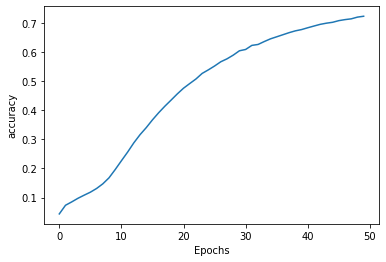

In [346]:
plot_graphs(model_info, 'accuracy')

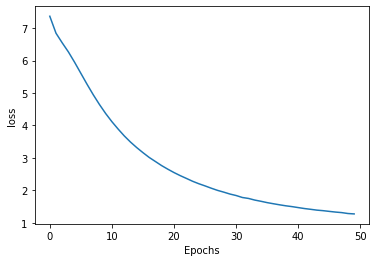

In [348]:
plot_graphs(model_info, 'loss')

### Next word prediction

In [349]:
def generate_text_with_model(seed_text, num_words, model, max_seq_len):
    generated_text = seed_text
    
    for _ in range(num_words):
        # Tokenize the current seed text
        token_list = tokenizer.texts_to_sequences([generated_text])[0]
        # Pad the token list to match the model's input length
        token_list = pad_sequences([token_list], maxlen=max_seq_len - 1, padding='pre')
        
        # Predict the next word probabilities using the model
        predicted_probs = model.predict(token_list)[0]
        # Sample the next word based on the predicted probabilities
        predicted_index = np.argmax(predicted_probs)
        
        # Find the predicted word corresponding to the index
        predicted_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted_index:
                predicted_word = word
                break
        
        # Update the generated text with the predicted word
        generated_text += " " + predicted_word
    
    # Capitalize the generated text and return it
    return generated_text.title()


In [354]:
print (generate_text_with_model("A Beginner’s Guide", 3, model, max_seq_len))
print (generate_text_with_model("guide to", 7, model, max_seq_len))
print (generate_text_with_model("implementation of", 4, model, max_seq_len))

1/1 [==============================] - 0s 24ms/step
A Beginner’S Guide To Reinforcement Learning
1/1 [==============================] - 0s 24ms/step
Guide To Choosing Hyperparameters For Your Neural Networks By
1/1 [==============================] - 0s 25ms/step
Implementation Of Rnn Lstm And Gru


#### Prepare Training and Test Data

In [280]:
def get_sequence_of_tokens(corpus, tokenizer):
    """
    Tokenize a corpus of text and create n-gram sequences.

    Parameters:
    corpus (list of str): A list of sentences.
    tokenizer: A pre-fitted tokenizer.

    Returns:
    input_sequences: A list of tokenized n-gram sequences.
    """
    
    # Convert data to token sequences
    input_sequences = []
    for line in corpus:
        token_list = tokenizer.texts_to_sequences([line])[0] #converts the line into a sequence of integers,
        for i in range(1, len(token_list)): #This loop is used to create n-gram sequences
            n_gram_sequence = token_list[:i+1]
            input_sequences.append(n_gram_sequence)
    
    return input_sequences

In [281]:
# Initialize the tokenizer and fit on the entire dataset
tokenizer = Tokenizer()
tokenizer.fit_on_texts(cleaned_headlines)

# Compute the total vocabulary size
vocab_size = len(tokenizer.word_index) + 1

# Split the dataset into training and test sets
train_corpus, test_corpus = train_test_split(cleaned_headlines, test_size=0.2, random_state=42)


# Tokenize and generate sequences for the training set
train_sequences = get_sequence_of_tokens(train_corpus, tokenizer)
train_predictors, train_label, train_max_seq_len = generate_padded_sequences(train_sequences, vocab_size)

# Tokenize and generate sequences for the test set
test_sequences = get_sequence_of_tokens(test_corpus, tokenizer)
test_predictors, test_label, _ = generate_padded_sequences(test_sequences, vocab_size, train_max_seq_len)


#### Create and train the Model

In [288]:
# Create the model
model = create_text_generation_model(max_seq_len, vocab_size)
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 23, 10)            121500    
                                                                 
 lstm_8 (LSTM)               (None, 100)               44400     
                                                                 
 dropout_8 (Dropout)         (None, 100)               0         
                                                                 
 dense_8 (Dense)             (None, 12150)             1227150   
                                                                 
Total params: 1,393,050
Trainable params: 1,393,050
Non-trainable params: 0
_________________________________________________________________


In [289]:
model.fit(train_predictors, train_label, epochs=50, verbose=1)

Epoch 1/50
1292/1292 [==============================] - 45s 33ms/step - loss: 7.9733
Epoch 2/50
1292/1292 [==============================] - 43s 33ms/step - loss: 7.5071
Epoch 3/50
1292/1292 [==============================] - 43s 33ms/step - loss: 7.3329
Epoch 4/50
1292/1292 [==============================] - 43s 33ms/step - loss: 7.1464
Epoch 5/50
1292/1292 [==============================] - 43s 33ms/step - loss: 6.9574
Epoch 6/50
1292/1292 [==============================] - 42s 32ms/step - loss: 6.7460
Epoch 7/50
1292/1292 [==============================] - 42s 33ms/step - loss: 6.5089
Epoch 8/50
1292/1292 [==============================] - 42s 33ms/step - loss: 6.2669
Epoch 9/50
1292/1292 [==============================] - 43s 33ms/step - loss: 6.0341
Epoch 10/50
1292/1292 [==============================] - 42s 33ms/step - loss: 5.8109
Epoch 11/50
1292/1292 [==============================] - 42s 33ms/step - loss: 5.6000
Epoch 12/50
1292/1292 [==============================] - 42s 33

#### Evaluate the Model

In [290]:
def evaluate_model_accuracy(model, test_predictors, test_labels):
    correct_predictions = 0
    test_labels_indices = np.argmax(test_labels, axis=1)
    
    for i in range(len(test_predictors)):
        sequence = np.array([test_predictors[i]])  # Reshape the sequence
        predicted_probs = model.predict(sequence)[0]
        predicted_index = np.argmax(predicted_probs)
        
        if predicted_index == test_labels_indices[i]:
            correct_predictions += 1

    accuracy = correct_predictions / len(test_predictors)
    return accuracy


In [291]:
accuracy = evaluate_model_accuracy(model, test_predictors, test_label)

1/1 [==============================] - 0s 20ms/step


In [292]:
print(f"Model Accuracy: {accuracy * 100:.2f}%")

Model Accuracy: 9.88%


https://www.analyticsvidhya.com/blog/2022/02/explaining-text-generation-with-lstm/